# Exporting an ImageCollection to NetCDF

## Introduction

[XEE](https://github.com/google/Xee) is a XArray extension that allows reading data from Google Earth Engine (GEE). This extension is useful for extracting subsets of data hosted in GEE. In this tutorial, we will learn how to extract a large ImageCollection and save it as a local NetCDF file.

## Overview of the Task

We will take the [ERA5-Land Daily Aggregated](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR) collection and export the subset for the chosen country as a CF-compatible format NetCDF file.

**Input Layers**:
* `ne_10m_admin_0_countries_ind.zip`: A shapefile of country boundaries

**Output**:
* `era5_subset.nc`: A NetCDF subset of the ERA5-Land Daily Aggregated data.

**Data Credit**:
- ERA5-Land monthly averaged data from 1981 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS).
- Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install xee rioxarray netCDF4

In [2]:
import ee
import geopandas as gpd
import numpy as np
import os
import rioxarray as rxr
import xarray as xr

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

shapefile = 'ne_10m_admin_0_countries_ind.zip'

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'
download('{}/{}'.format(data_url,shapefile))

Downloaded data/ne_10m_admin_0_countries_ind.zip


Initialize EE with the [High-Volume EndPoint](https://developers.google.com/earth-engine/guides/processing_environments#high-volume_endpoint) recommended to be used with XEE. Replace the value of the `cloud_project` variable with your own project id that is linked with GEE.


In [5]:
cloud_project = 'spatialthoughts' # replace with your project id

try:
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com')

## Data Preparation

We read the Natural Earth administrative regions shapefile and select a country.

In [6]:
shapefile_path = os.path.join(data_folder, shapefile)
boundaries_gdf = gpd.read_file(shapefile_path)

Select the country of your choice using the [3-letter ISO code](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) for your country. Here we use `GHA` for Ghana.

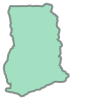

In [21]:
country = boundaries_gdf[boundaries_gdf['ADM0_A3'] == 'GHA']
geometry = country.geometry.union_all()

Configure the time period and variables.

In [8]:
start_year = 2023
end_year = 2024
variable = 'temperature_2m'

Open the subset using XEE. Define the ImageCollection and apply filters using the Earth Engine Python API syntax.

In [ ]:
start_date = ee.Date.fromYMD(start_year, 1, 1)
end_date = ee.Date.fromYMD(end_year + 1, 1, 1)
bbox = ee.Algorithms.GeometryConstructors.BBox(*geometry.bounds)

era5 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
filtered = era5 \
  .filter(ee.Filter.date(start_date, end_date)) \
  .filter(ee.Filter.bounds(bbox)) \
  .select(variable)

XArray can open the filtered collection directly from GEE if the XEE extension is installed.

In [16]:
ds = xr.open_dataset(
    filtered,
    engine='ee',
    geometry=bbox,
    projection=filtered.first().select(0).projection(),
    fast_time_slicing=True,
    chunks={'index': 24},
)
ds

<xarray.Dataset> Size: 8MB
Dimensions:         (time: 731, lon: 45, lat: 64)
Coordinates:
  * time            (time) datetime64[ns] 6kB 2023-01-01 ... 2024-12-31
  * lon             (lon) float64 360B -3.213 -3.113 -3.013 ... 1.087 1.187
  * lat             (lat) float64 512B 11.11 11.01 10.91 ... 5.013 4.913 4.813
Data variables:
    temperature_2m  (time, lon, lat) float32 8MB dask.array<chunksize=(48, 45, 64), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

XEE queries the data for the bounding box of the provided geometry. So we still need to clip the pixels outside the geometry. We rename the `lat` and `lon` dimensions to `y` and `x` to make it compatible with `rioxarray` and clip it.

In [23]:
clipped_ds = ds \
  .rename({'lon': 'x', 'lat':'y'}) \
  .rio.clip(country.geometry.values)

## Export

Prepare the data for export. Currently XEE produces dataset with dimension ordering that is different than what is expected by many other Python/R packages. We transpose the data to fix this as [recommended by XEE developers](https://github.com/google/Xee/issues/171).

In [12]:
export_ds = clipped_ds.transpose()

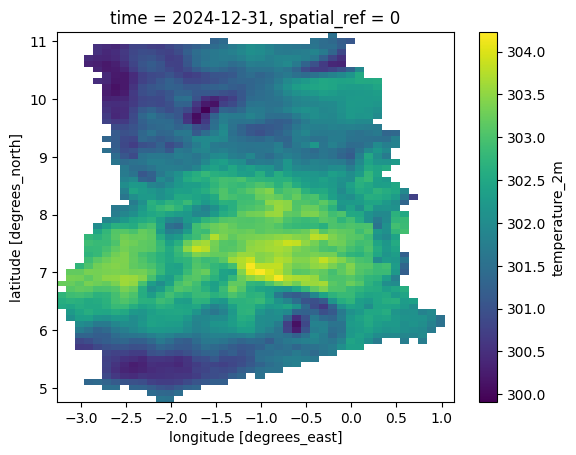

In [13]:
# Plot a single timestep to verify the data
export_ds[variable].isel(time=-1).plot.imshow()

Save the results as a NetCDF file.

In [14]:
%%time
output_file = f'era5_subset.nc'
output_path = os.path.join(output_folder, output_file)

# Enable compression
encoding = {variable: {'zlib': True}}
export_ds.to_netcdf(output_path, encoding=encoding)

CPU times: user 567 ms, sys: 105 ms, total: 672 ms
Wall time: 6.76 s


----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>